# Plot data by category

Export pedigree data and tensile test results for composite materials, process the data in a `pandas` DataFrame, and plot summaries of the data (including layup information) using `matplotlib` and `seaborn`.

## Get data from Granta MI

Connect to Granta MI and specify a database.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mi

session = mi.Session('localhost', autologon=True)
training_db = session.get_db('MI Training')
training_db.set_unit_system('Metric')

Specify the records and attributes you want to export from the first table. We want to use attributes describing the layup for all records in the *Composite Pedigree* table.

In [2]:
comp_pedigree = training_db.get_table('Composite Pedigree')
pedigree_records = comp_pedigree.all_records()
pedigree_attributes = ['Panel number', 'Ply count', 'Panel thickness, average (measured)',
                       'Ply thickness, average (measured)']
comp_pedigree.bulk_fetch(pedigree_records, attributes=pedigree_attributes)

Specify the records you want to export from the second table. Here, a link group is used to export only records linked to records in the first table.

Alternatively, you can specify a table with no link groups to the original table, as long as you can join the two datasets later on. For example, we could search for all records created after a certain date, or tested on a certain machine.

In [3]:
link_group = 'Tensile test data'

# Use a set comprehension to ensure we only select each record once
tensile_test_records = {tr for pr in pedigree_records for tr in pr.links[link_group]}
tensile_test_records = list(tensile_test_records)

Specify the attributes you want to export from the second table. *Panel number* will be used to relate the tensile tests to the layup data.

In [4]:
tensile_test_data = training_db.get_table('Tensile Test Data')
tensile_attributes = ['Panel number', 'Specimen ID', 'Ultimate Tensile Strength', 'Test Type']
tensile_test_data.bulk_fetch(tensile_test_records, attributes=tensile_attributes)

## Use DataFrames to pre-process and append the data

### Build a separate DataFrame for each table

Create a DataFrame for each Granta MI table. The DataFrames are built from two separate lists of dictionaries:

In [5]:
import pandas as pd
from functools import partial

def get_attr_vals(attributes, r):
    return {mi_attr: r.attributes[mi_attr].value for mi_attr in attributes}

get_pedigree_vals = partial(get_attr_vals, pedigree_attributes)
get_tensile_vals = partial(get_attr_vals, tensile_attributes)

pedigree_data = [get_pedigree_vals(r) for r in pedigree_records]
tensile_data = [get_tensile_vals(r) for r in tensile_test_records]

Create a DataFrame `pedigree_df` that contains the pedigree records. Set the DataFrame index to be the *Panel number*
attribute value.

In [6]:
pedigree_df = pd.DataFrame(pedigree_data).set_index('Panel number')
pedigree_df.head()

Ply count  Panel thickness, average (measured)  \
Panel number                                                   
LBJ13                 6                             1.397000   
LBJ14                 6                             1.431636   
LBJ42                 6                             1.438564   
LBJ53                 6                             1.385455   
LBJ62                 6                             1.410677   

              Ply thickness, average (measured)  
Panel number                                     
LBJ13                                  0.232029  
LBJ14                                  0.238044  
LBJ42                                  0.240007  
LBJ53                                  0.231279  
LBJ62                                  0.234618

Create a second DataFrame `tensile_df` that contains the tensile test results. Again, set the index to be the *Panel
number* attribute value.

In [7]:
tensile_df = pd.DataFrame(tensile_data).set_index('Panel number')
tensile_df.head()

Specimen ID  Ultimate Tensile Strength   Test Type
Panel number                                                   
LBJ62           LBJ6218A                1309.231786  0° tension
LBJ42           LBJ421BA                1624.411854  0° tension
LBJ83           LBJ831CA                1605.651217  0° tension
LBJ53           LBJ5315A                1525.947816  0° tension
LBJ83           LBJ8312A                1626.776755  0° tension

### Join the dataframes

Use the `dataframe.join()` method to create a DataFrame with both sets of data. The join type will default to a left-join if not specified; this is fine in our case because the records were linked via a smart link in Granta MI, and so the set of indices is the same for both DataFrames.

In [8]:
df = pedigree_df.join(tensile_df)
df.head()

Ply count  Panel thickness, average (measured)  \
Panel number                                                   
LBJ13                 6                             1.397000   
LBJ13                 6                             1.397000   
LBJ13                 6                             1.397000   
LBJ14                 6                             1.431636   
LBJ14                 6                             1.431636   

              Ply thickness, average (measured) Specimen ID  \
Panel number                                                  
LBJ13                                  0.232029    LBJ1311A   
LBJ13                                  0.232029    LBJ1312A   
LBJ13                                  0.232029    LBJ1313A   
LBJ14                                  0.238044    LBJ1418A   
LBJ14                                  0.238044    LBJ1413A   

              Ultimate Tensile Strength   Test Type  
Panel number                                         
LBJ13                       1582.870937  0° tension  
LBJ13                       1542.122918  0° tension  
LBJ13                       1612.952766  0° tension  
LBJ14                       1622.040057  0° tension  
LBJ14                       1613.614663  0° tension

### Units

Finally, create a `units` dict so you can create plots with meaningful axis labels.

In [9]:
attr_defs = [comp_pedigree.attributes[attr] for attr in pedigree_attributes] + \
            [tensile_test_data.attributes[attr] for attr in tensile_attributes]
units = {attr.name: attr.unit for attr in attr_defs if attr.unit}
units

{'Panel thickness, average (measured)': 'mm',
 'Ply thickness, average (measured)': 'mm',
 'Ultimate Tensile Strength': 'MPa'}

## Plot the data

This code snippet is optional, and is included to increase the size of all plots generated in this
notebook.

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

### Investigate the relationship between two properties

Create a scatter plot with `matplotlib` comparing *Ultimate Tensile Strength* of the panels to *Ply thickness, average*.

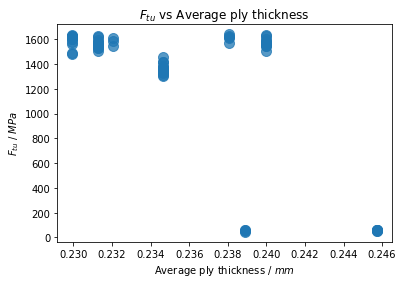

In [11]:
import matplotlib.pyplot as plt

ply_thickness_unit = units['Ply thickness, average (measured)']
ftu_unit = units["Ultimate Tensile Strength"]
ply_thickness_label = rf'Average ply thickness / ${ply_thickness_unit}$'
ftu_label = rf'$F_{{tu}}$ / ${ftu_unit}$'

fig, ax = plt.subplots()
ax.scatter(data=df, x="Ply thickness, average (measured)", y="Ultimate Tensile Strength", alpha=0.75, s=100)
ax.set_xlabel(ply_thickness_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title(r'$F_{tu}$ vs Average ply thickness')

There is a significant difference between the results at 1200 - 1600 MPa and the group below 100 MPa. We need to identify what causes this difference, and then represent the data in a clearer way.

### Investigate the impact of other properties

First, examine the underlying data; use the `DataFrame.describe()` method to view a statistical summary of the data in each column.

In [12]:
df.describe(include='all')

Ply count  Panel thickness, average (measured)  \
count   67.000000                            67.000000   
unique        NaN                                  NaN   
top           NaN                                  NaN   
freq          NaN                                  NaN   
mean     6.492537                             1.534167   
std      1.119701                             0.294450   
min      6.000000                             1.379415   
25%      6.000000                             1.385455   
50%      6.000000                             1.410677   
75%      6.000000                             1.438564   
max      9.000000                             2.213429   

        Ply thickness, average (measured) Specimen ID  \
count                           67.000000          67   
unique                                NaN          67   
top                                   NaN    LBJ4213A   
freq                                  NaN           1   
mean                             0.235604         NaN   
std                              0.005039         NaN   
min                              0.229948         NaN   
25%                              0.231279         NaN   
50%                              0.234618         NaN   
75%                              0.240007         NaN   
max                              0.245727         NaN   

        Ultimate Tensile Strength   Test Type  
count                   67.000000          67  
unique                        NaN           2  
top                           NaN  0° tension  
freq                          NaN          56  
mean                  1288.110261         NaN  
std                    557.743977         NaN  
min                     44.629768         NaN  
25%                   1353.613343         NaN  
50%                   1545.653034         NaN  
75%                   1603.610369         NaN  
max                   1639.559637         NaN

The *Test Type* column summary shows that the most frequent value is '0° tension' (as expected), but there are 9 occurrences of a second test type.

To identify all possible values in the *Test Type* column, use `DataFrame['Test Type'].unique()`.

In [13]:
df['Test Type'].unique()

array(['0° tension', '90° tension'], dtype=object)

Although there is only one populated attribute for *Ultimate Tensile Strength* and *Young's modulus*, the *Test Type* column shows that the tensile tests were performed in two different directions. 

Since composite materials are often highly orthotropic, the direction of the test must be taken into account when plotting the results. We can filter the DataFrame based on the *Test Type* column when plotting:

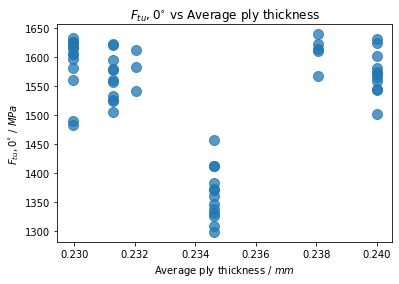

In [14]:
ftu_0_label = rf'$F_{{tu}}, 0^{{\circ}}$ / ${ftu_unit}$'
df_0_tension = df[df['Test Type'] == '0° tension']

fig, ax = plt.subplots()
ax.scatter(data=df_0_tension,
           x="Ply thickness, average (measured)",
           y="Ultimate Tensile Strength",
           alpha=0.75,
           s=100)
ax.set_xlabel(ply_thickness_label)
ax.set_ylabel(ftu_0_label)
_ = ax.set_title(r'$F_{tu}, 0^{{\circ}}$ vs Average ply thickness')

We can also overlay the 90° *Ultimate Tensile Strength* results, using `.twinx()` to plot them on a separate y-axis.

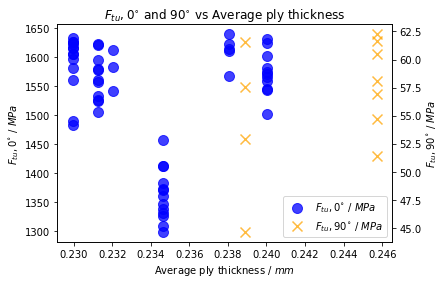

In [15]:
ftu_90_label = rf'$F_{{tu}}, 90^{{\circ}}$ / ${ftu_unit}$'
df_90_tension = df[df['Test Type'] == '90° tension']

fig, ax1 = plt.subplots()
ax1.scatter(data=df_0_tension,
            x="Ply thickness, average (measured)",
            y="Ultimate Tensile Strength",
            color="blue",
            marker="o",
            alpha=0.75,
            s=100)
ax2 = plt.twinx()
ax2.scatter(data=df_90_tension,
            x="Ply thickness, average (measured)",
            y="Ultimate Tensile Strength",
            color="orange",
            marker="x",
            alpha=0.75,
            s=100)

ax1.set_xlabel(ply_thickness_label)
ax1.set_ylabel(ftu_0_label)
ax2.set_ylabel(ftu_90_label)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.legend(h1+h2, [ftu_0_label, ftu_90_label], loc='lower right')
_ = ax1.set_title(r'$F_{tu}, 0^{{\circ}}$ and $90^{{\circ}}$ vs Average ply thickness')